In [26]:
import json
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path

class PoseLiftFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.samples = []
        folder_path = Path(folder_path)
        json_files = list(folder_path.glob("*.json"))

        for json_file in json_files:
            with open(json_file, "r") as f:
                data = json.load(f)

            for pid, frames in data.items():
                for fid, content in frames.items():
                    keypoints = np.array(content["keypoints"], dtype=np.float32)
                    keypoints = keypoints.reshape(-1, 3)[:, :2].flatten()  # keep x,y only
                    self.samples.append(keypoints)

        self.samples = np.array(self.samples)
        print(f"Loaded {len(self.samples)} samples from {folder_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx], dtype=torch.float32)
        return x, x  # autoencoder-style


In [23]:
import torch.nn as nn

class PoseNet(nn.Module):
    def __init__(self, input_dim=34*2, hidden_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.model(x)


In [25]:
def train_model(model, dataloader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {total_loss/len(dataloader):.4f}")


In [40]:
if __name__ == "__main__":
    train_folder = "pose/train"
    test_folder = "pose/test"

    train_ds = PoseLiftFolderDataset(train_folder)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    input_dim = train_ds[0][0].shape[0]
    model = PoseNet(input_dim=input_dim)

    train_model(model, train_loader, epochs=50)
    torch.save(model.state_dict(), "pose_model.pth")

    print("✅ Model saved to pose_model.pth")



Loaded 79632 samples from pose/train
Epoch [1/50]  Loss: 995.8231
Epoch [2/50]  Loss: 74.6599
Epoch [3/50]  Loss: 43.4709
Epoch [4/50]  Loss: 39.3062
Epoch [5/50]  Loss: 22.4341
Epoch [6/50]  Loss: 18.9624
Epoch [7/50]  Loss: 18.6762
Epoch [8/50]  Loss: 17.1814
Epoch [9/50]  Loss: 14.2556
Epoch [10/50]  Loss: 12.4566
Epoch [11/50]  Loss: 11.7260
Epoch [12/50]  Loss: 13.7393
Epoch [13/50]  Loss: 10.2067
Epoch [14/50]  Loss: 9.7258
Epoch [15/50]  Loss: 11.0710
Epoch [16/50]  Loss: 9.4935
Epoch [17/50]  Loss: 9.6393
Epoch [18/50]  Loss: 10.5943
Epoch [19/50]  Loss: 8.2378
Epoch [20/50]  Loss: 7.9229
Epoch [21/50]  Loss: 8.7612
Epoch [22/50]  Loss: 7.5897
Epoch [23/50]  Loss: 8.3598
Epoch [24/50]  Loss: 7.6483
Epoch [25/50]  Loss: 7.1439
Epoch [26/50]  Loss: 7.3256
Epoch [27/50]  Loss: 6.8777
Epoch [28/50]  Loss: 7.2148
Epoch [29/50]  Loss: 6.0958
Epoch [30/50]  Loss: 6.1704
Epoch [31/50]  Loss: 6.7475
Epoch [32/50]  Loss: 6.8030
Epoch [33/50]  Loss: 5.3100
Epoch [34/50]  Loss: 7.1878
Epoc

In [41]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
import json
  # replace 'your_file' with your .py filename

# ---- Paths ----
test_folder = "pose/test"
model_path = "pose_model.pth"

# ---- Load Test Data ----
test_ds = PoseLiftFolderDataset(test_folder)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# ---- Load Model ----
input_dim = test_ds[0][0].shape[0]
model = PoseNet(input_dim=input_dim)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

print(f"✅ Loaded model from {model_path}")


Loaded 4620 samples from pose/test
✅ Loaded model from pose_model.pth


In [42]:
import torch.nn.functional as F

errors = []

with torch.no_grad():
    for x, _ in test_loader:
        y_pred = model(x)
        loss = F.mse_loss(y_pred, x, reduction='none')
        loss_per_sample = loss.mean(dim=1)  # average error per pose
        errors.extend(loss_per_sample.numpy())

errors = np.array(errors)
print(f"Average reconstruction error: {errors.mean():.6f}")
print(f"Std deviation: {errors.std():.6f}")


Average reconstruction error: 4.604090
Std deviation: 3.981136


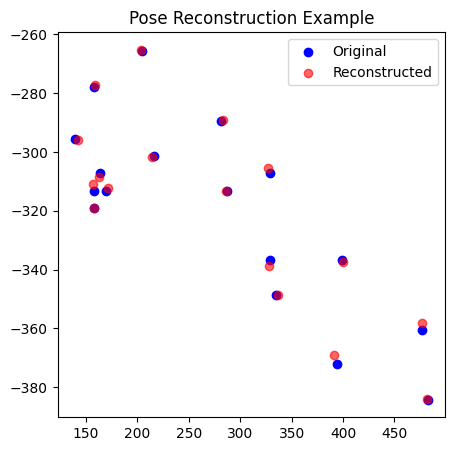

In [43]:
import matplotlib.pyplot as plt

# get a random example
x, _ = test_ds[0]
x = x.unsqueeze(0)
with torch.no_grad():
    y_pred = model(x)

x_np = x.squeeze().numpy().reshape(-1, 2)
y_np = y_pred.squeeze().numpy().reshape(-1, 2)

plt.figure(figsize=(5,5))
plt.scatter(x_np[:,0], -x_np[:,1], label="Original", c="blue")
plt.scatter(y_np[:,0], -y_np[:,1], label="Reconstructed", c="red", alpha=0.6)
plt.legend()
plt.title("Pose Reconstruction Example")
plt.show()


VIDEO1.MP4

Loaded 2601 frames from pose/video1_poselift_3d.json
Average reconstruction error: 236.9241
Highest error: 3783.0017
Lowest error: 1.8848


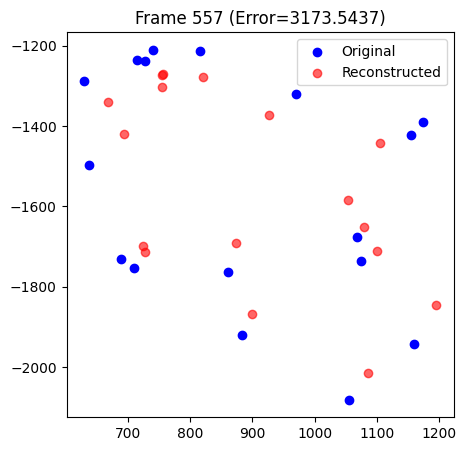

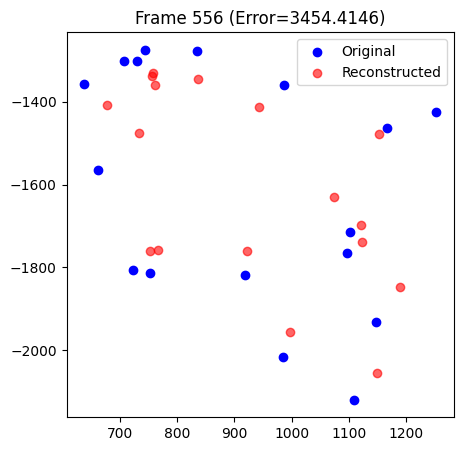

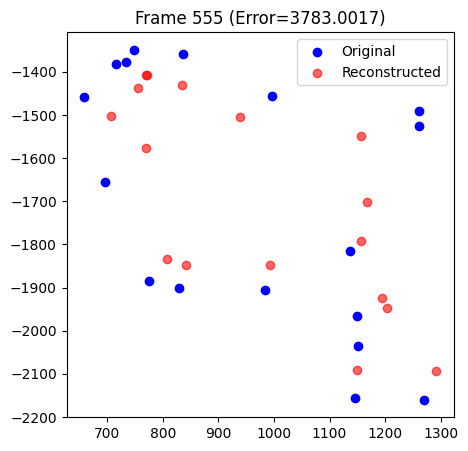

In [86]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Model (same as before)
# -----------------------------
class PoseNet(nn.Module):
    def __init__(self, input_dim=34*2, hidden_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        return self.model(x)

# -----------------------------
# Dataset for ONE JSON file
# -----------------------------
class PoseLiftSingleJSON(Dataset):
    def __init__(self, json_path):
        self.samples = []
        data = json.load(open(json_path))

        for pid, frames in data.items():
            for fid, content in frames.items():
                # ✅ content is a list of keypoints [x1, y1, conf1, x2, y2, conf2, ...]
                keypoints = np.array(content, dtype=np.float32)
                keypoints = keypoints.reshape(-1, 3)[:, :2].flatten()  # keep x,y only
                self.samples.append(keypoints)

        self.samples = np.array(self.samples)
        print(f"Loaded {len(self.samples)} frames from {json_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx], dtype=torch.float32)
        return x, x

# -----------------------------
# Visualization helper
# -----------------------------
def visualize_pose(original, reconstructed, title="Pose Comparison"):
    plt.figure(figsize=(5,5))
    plt.scatter(original[:,0], -original[:,1], c='blue', label='Original')
    plt.scatter(reconstructed[:,0], -reconstructed[:,1], c='red', alpha=0.6, label='Reconstructed')
    plt.legend()
    plt.title(title)
    plt.show()

# -----------------------------
# Compute reconstruction errors
# -----------------------------
def compute_errors(json_path, model_path="pose_model.pth"):
    ds = PoseLiftSingleJSON(json_path)
    dl = DataLoader(ds, batch_size=1, shuffle=False)

    input_dim = ds[0][0].shape[0]
    model = PoseNet(input_dim=input_dim)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    errors = []
    reconstructions = []

    with torch.no_grad():
        for x, _ in dl:
            y_pred = model(x)
            loss = F.mse_loss(y_pred, x, reduction='none').mean().item()
            errors.append(loss)
            reconstructions.append(y_pred.squeeze().numpy())

    errors = np.array(errors)
    print(f"Average reconstruction error: {errors.mean():.4f}")
    print(f"Highest error: {errors.max():.4f}")
    print(f"Lowest error: {errors.min():.4f}")
    return ds.samples, errors, reconstructions

# -----------------------------
# Main function
# -----------------------------
def test_single_json(json_path, model_path="pose_model.pth", show_top_errors=3):
    ds = PoseLiftSingleJSON(json_path)
    dl = DataLoader(ds, batch_size=1, shuffle=False)

    input_dim = ds[0][0].shape[0]
    model = PoseNet(input_dim=input_dim)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    errors = []
    reconstructions = []

    with torch.no_grad():
        for x, _ in dl:
            y_pred = model(x)
            loss = F.mse_loss(y_pred, x, reduction='none').mean().item()
            errors.append(loss)
            reconstructions.append(y_pred.squeeze().numpy())

    errors = np.array(errors)
    print(f"Average reconstruction error: {errors.mean():.4f}")
    print(f"Highest error: {errors.max():.4f}")
    print(f"Lowest error: {errors.min():.4f}")

    # show top few high-error frames
    worst_idxs = np.argsort(errors)[-show_top_errors:]
    for i in worst_idxs:
        x_np = ds.samples[i].reshape(-1, 2)
        y_np = reconstructions[i].reshape(-1, 2)
        visualize_pose(x_np, y_np, title=f"Frame {i} (Error={errors[i]:.4f})")

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    test_json_path = "pose/video1_poselift_3d.json"  # 👈 replace with your file path
    test_single_json(test_json_path)


In [74]:
# -----------------------------
# Visualize top error frames
# -----------------------------
def show_top_error_frames(samples, reconstructions, errors, top_k=3):
    worst_idxs = np.argsort(errors)[-top_k:]
    for i in worst_idxs:
        x_np = samples[i].reshape(-1, 2)
        y_np = reconstructions[i].reshape(-1, 2)
        visualize_pose(x_np, y_np, title=f"Frame {i} (Error={errors[i]:.4f})")

In [75]:
# -----------------------------
# Overlay anomalies on video
# -----------------------------
def visualize_anomalies(video_path, frame_errors, output_path="output_with_anomalies_1.mp4", threshold=None):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If threshold not provided, auto compute
    frame_errors = np.array(frame_errors)
    if threshold is None:
        mean_err = np.mean(frame_errors)
        std_err = np.std(frame_errors)
        threshold = mean_err + 2 * std_err
        print(f"Auto threshold: {threshold:.3f}")
    
    # Prepare video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # CSV to log anomalies
    csv_path = os.path.splitext(output_path)[0] + "_timestamps.csv"
    csv_file = open(csv_path, "w", newline="")
    writer = csv.writer(csv_file)
    writer.writerow(["Frame", "Timestamp (s)", "Error"])

    frame_idx = 0
    error_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret or error_idx >= len(frame_errors):
            break

        # Align frame to error index safely
        err = frame_errors[error_idx]
        if err > threshold:
            timestamp = error_idx / fps
            writer.writerow([error_idx, f"{timestamp:.2f}", f"{err:.3f}"])
            cv2.putText(frame, "⚠️ Anomaly Detected", (50, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3, cv2.LINE_AA)
            cv2.rectangle(frame, (20, 20), (width-20, height-20), (0, 0, 255), 5)
        
        out.write(frame)
        frame_idx += 1
        error_idx += 1  # assumes 1:1 alignment JSON frame <-> video frame

    cap.release()
    out.release()
    csv_file.close()
    print(f"✅ Saved annotated video: {output_path}")
    print(f"✅ Saved anomaly timestamps: {csv_path}")

In [76]:
# -----------------------------
# Optional: plot error over time
# -----------------------------
def plot_error_over_time(frame_errors):
    plt.figure(figsize=(12,4))
    plt.plot(frame_errors, label="Reconstruction Error")
    threshold = np.mean(frame_errors) + 2*np.std(frame_errors)
    plt.axhline(threshold, color='r', linestyle='--', label="Threshold")
    plt.xlabel("Frame Index")
    plt.ylabel("Error")
    plt.title("Frame-wise Reconstruction Error")
    plt.legend()
    plt.show()

Loaded 2601 frames from pose/video1_poselift_3d.json
Average reconstruction error: 236.9241
Highest error: 3783.0017
Lowest error: 1.8848


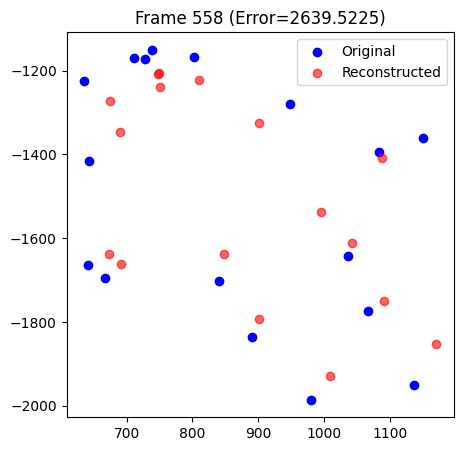

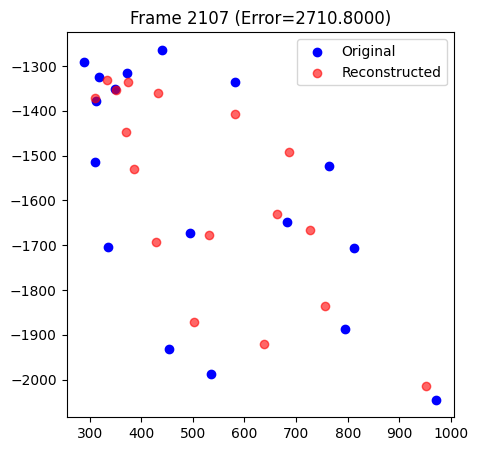

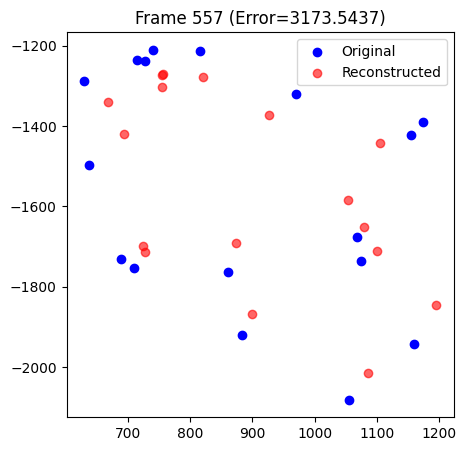

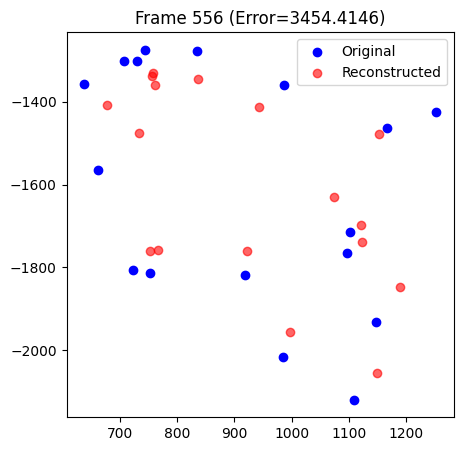

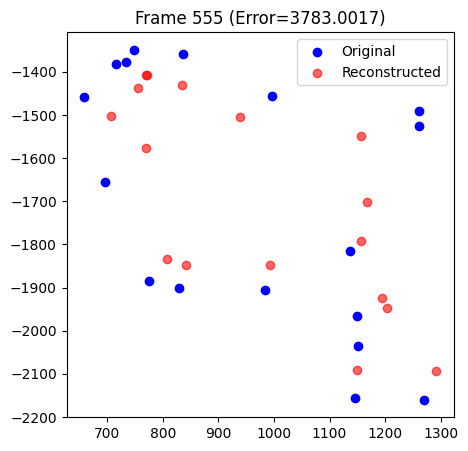

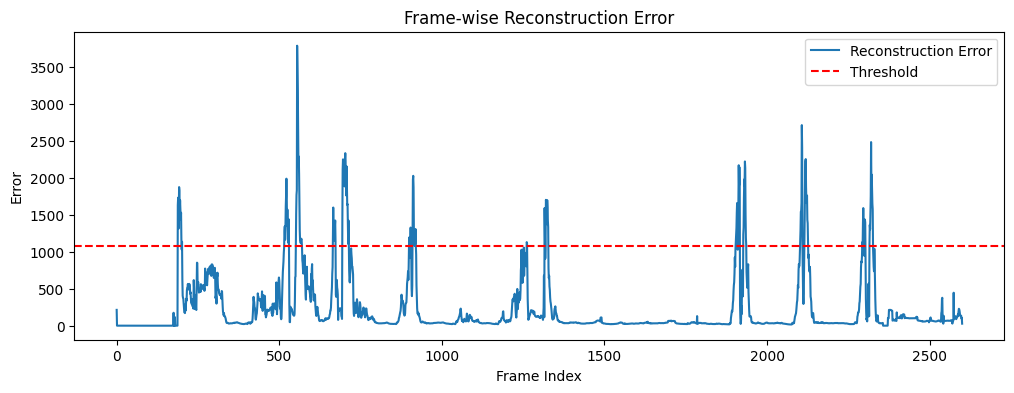

Auto threshold: 1083.684
✅ Saved annotated video: video1_anomalies.mp4
✅ Saved anomaly timestamps: video1_anomalies_timestamps.csv


In [77]:
# -----------------------------
# Full pipeline
# -----------------------------
if __name__ == "__main__":
    json_path = "pose/video1_poselift_3d.json"  # replace
    model_path = "pose_model.pth"
    video_path = "video1.mp4"
    
    # 1️⃣ Compute errors
    samples, errors, reconstructions = compute_errors(json_path, model_path)
    
    # 2️⃣ Show top-error frames
    show_top_error_frames(samples, reconstructions, errors, top_k=5)
    
    # 3️⃣ Plot error over time
    plot_error_over_time(errors)
    
    # 4️⃣ Visualize anomalies on video and save CSV
    visualize_anomalies(video_path, errors, output_path="video1_anomalies.mp4")

VIDEO 2.MP4

Loaded 200 frames from pose/video2_poselift_3d.json
Average reconstruction error: 2.5682
Highest error: 3.3010
Lowest error: 1.8848


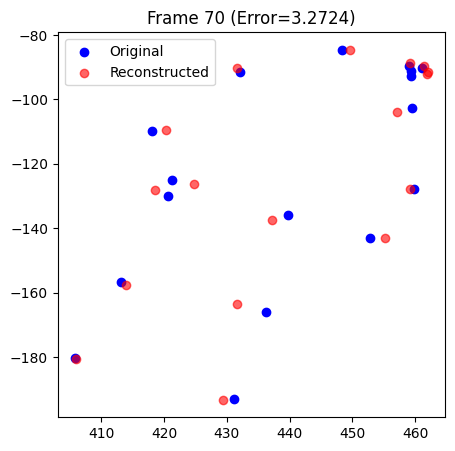

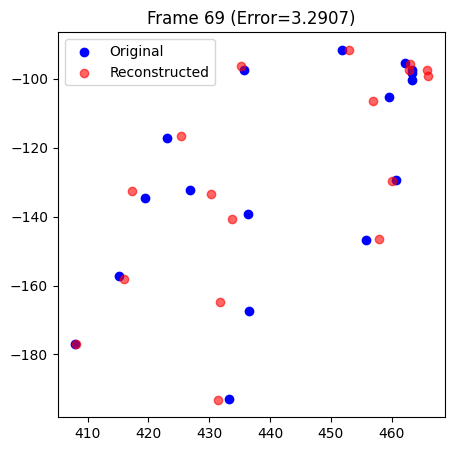

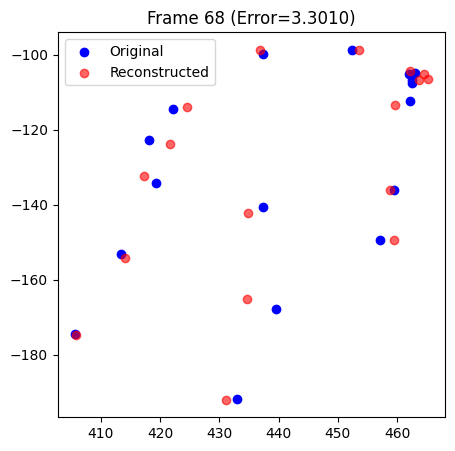

In [78]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Model (same as before)
# -----------------------------
class PoseNet(nn.Module):
    def __init__(self, input_dim=34*2, hidden_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        return self.model(x)

# -----------------------------
# Dataset for ONE JSON file
# -----------------------------
class PoseLiftSingleJSON(Dataset):
    def __init__(self, json_path):
        self.samples = []
        data = json.load(open(json_path))

        for pid, frames in data.items():
            for fid, content in frames.items():
                # ✅ content is a list of keypoints [x1, y1, conf1, x2, y2, conf2, ...]
                keypoints = np.array(content, dtype=np.float32)
                keypoints = keypoints.reshape(-1, 3)[:, :2].flatten()  # keep x,y only
                self.samples.append(keypoints)

        self.samples = np.array(self.samples)
        print(f"Loaded {len(self.samples)} frames from {json_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx], dtype=torch.float32)
        return x, x

# -----------------------------
# Visualization helper
# -----------------------------
def visualize_pose(original, reconstructed, title="Pose Comparison"):
    plt.figure(figsize=(5,5))
    plt.scatter(original[:,0], -original[:,1], c='blue', label='Original')
    plt.scatter(reconstructed[:,0], -reconstructed[:,1], c='red', alpha=0.6, label='Reconstructed')
    plt.legend()
    plt.title(title)
    plt.show()

# -----------------------------
# Compute reconstruction errors
# -----------------------------
def compute_errors(json_path, model_path="pose_model.pth"):
    ds = PoseLiftSingleJSON(json_path)
    dl = DataLoader(ds, batch_size=1, shuffle=False)

    input_dim = ds[0][0].shape[0]
    model = PoseNet(input_dim=input_dim)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    errors = []
    reconstructions = []

    with torch.no_grad():
        for x, _ in dl:
            y_pred = model(x)
            loss = F.mse_loss(y_pred, x, reduction='none').mean().item()
            errors.append(loss)
            reconstructions.append(y_pred.squeeze().numpy())

    errors = np.array(errors)
    print(f"Average reconstruction error: {errors.mean():.4f}")
    print(f"Highest error: {errors.max():.4f}")
    print(f"Lowest error: {errors.min():.4f}")
    return ds.samples, errors, reconstructions

# -----------------------------
# Main function
# -----------------------------
def test_single_json(json_path, model_path="pose_model.pth", show_top_errors=3):
    ds = PoseLiftSingleJSON(json_path)
    dl = DataLoader(ds, batch_size=1, shuffle=False)

    input_dim = ds[0][0].shape[0]
    model = PoseNet(input_dim=input_dim)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    errors = []
    reconstructions = []

    with torch.no_grad():
        for x, _ in dl:
            y_pred = model(x)
            loss = F.mse_loss(y_pred, x, reduction='none').mean().item()
            errors.append(loss)
            reconstructions.append(y_pred.squeeze().numpy())

    errors = np.array(errors)
    print(f"Average reconstruction error: {errors.mean():.4f}")
    print(f"Highest error: {errors.max():.4f}")
    print(f"Lowest error: {errors.min():.4f}")

    # show top few high-error frames
    worst_idxs = np.argsort(errors)[-show_top_errors:]
    for i in worst_idxs:
        x_np = ds.samples[i].reshape(-1, 2)
        y_np = reconstructions[i].reshape(-1, 2)
        visualize_pose(x_np, y_np, title=f"Frame {i} (Error={errors[i]:.4f})")

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    test_json_path = "pose/video2_poselift_3d.json"  # 👈 replace with your file path
    test_single_json(test_json_path)


In [79]:
# -----------------------------
# Visualize top error frames
# -----------------------------
def show_top_error_frames(samples, reconstructions, errors, top_k=3):
    worst_idxs = np.argsort(errors)[-top_k:]
    for i in worst_idxs:
        x_np = samples[i].reshape(-1, 2)
        y_np = reconstructions[i].reshape(-1, 2)
        visualize_pose(x_np, y_np, title=f"Frame {i} (Error={errors[i]:.4f})")

In [80]:
# -----------------------------
# Overlay anomalies on video
# -----------------------------
def visualize_anomalies(video_path, frame_errors, output_path="output_with_anomalies_2.mp4", threshold=None):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If threshold not provided, auto compute
    frame_errors = np.array(frame_errors)
    if threshold is None:
        mean_err = np.mean(frame_errors)
        std_err = np.std(frame_errors)
        threshold = mean_err + 2 * std_err
        print(f"Auto threshold: {threshold:.3f}")
    
    # Prepare video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # CSV to log anomalies
    csv_path = os.path.splitext(output_path)[0] + "_timestamps.csv"
    csv_file = open(csv_path, "w", newline="")
    writer = csv.writer(csv_file)
    writer.writerow(["Frame", "Timestamp (s)", "Error"])

    frame_idx = 0
    error_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret or error_idx >= len(frame_errors):
            break

        # Align frame to error index safely
        err = frame_errors[error_idx]
        if err > threshold:
            timestamp = error_idx / fps
            writer.writerow([error_idx, f"{timestamp:.2f}", f"{err:.3f}"])
            cv2.putText(frame, "Anomaly Detected", (50, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3, cv2.LINE_AA)
            cv2.rectangle(frame, (20, 20), (width-20, height-20), (0, 0, 255), 5)
        
        out.write(frame)
        frame_idx += 1
        error_idx += 1  # assumes 1:1 alignment JSON frame <-> video frame

    cap.release()
    out.release()
    csv_file.close()
    print(f"Saved annotated video: {output_path}")
    print(f"Saved anomaly timestamps: {csv_path}")

In [81]:
# -----------------------------
# Optional: plot error over time
# -----------------------------
def plot_error_over_time(frame_errors):
    plt.figure(figsize=(12,4))
    plt.plot(frame_errors, label="Reconstruction Error")
    threshold = np.mean(frame_errors) + 2*np.std(frame_errors)
    plt.axhline(threshold, color='r', linestyle='--', label="Threshold")
    plt.xlabel("Frame Index")
    plt.ylabel("Error")
    plt.title("Frame-wise Reconstruction Error")
    plt.legend()
    plt.show()

Loaded 200 frames from pose/video2_poselift_3d.json
Average reconstruction error: 2.5682
Highest error: 3.3010
Lowest error: 1.8848


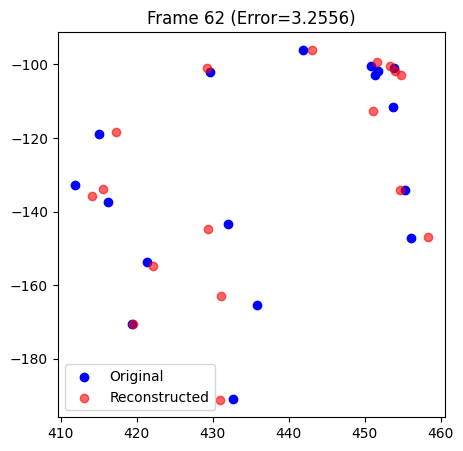

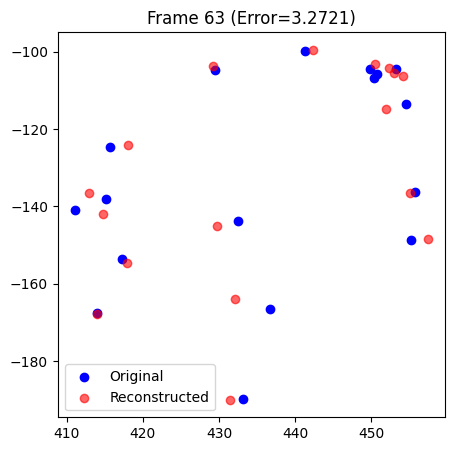

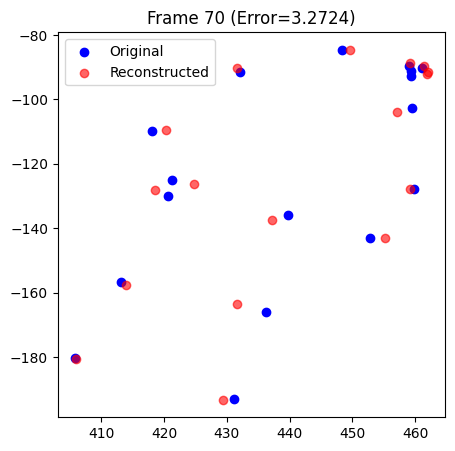

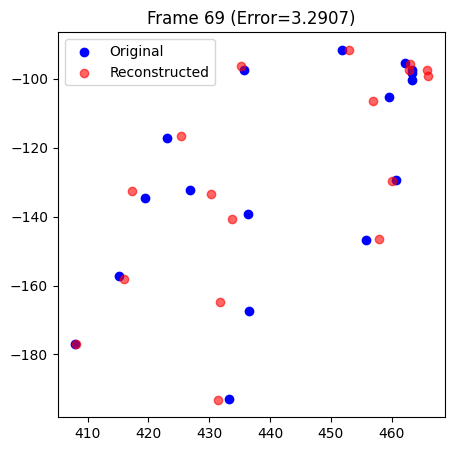

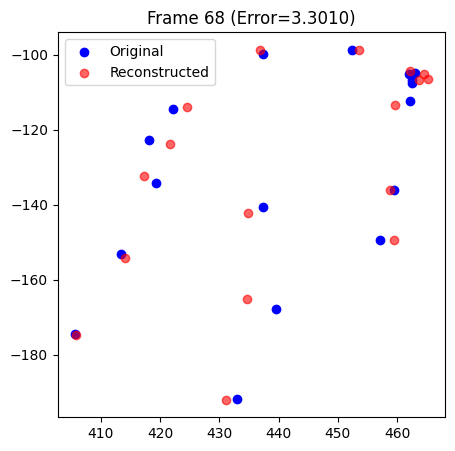

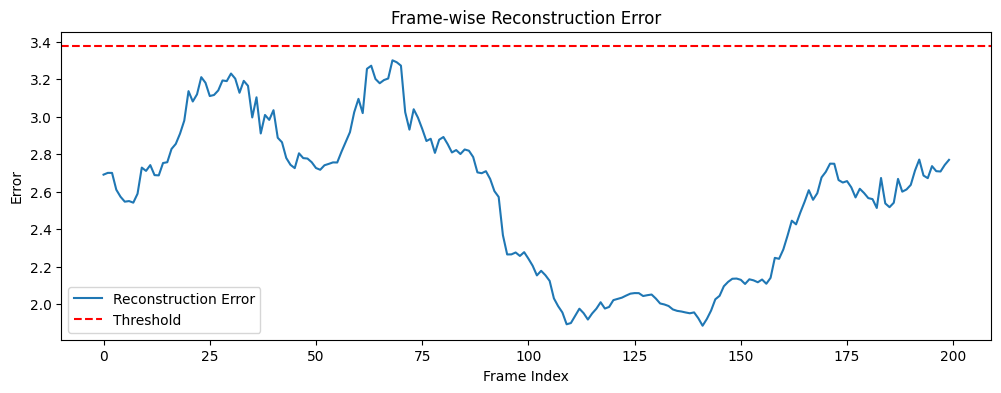

Auto threshold: 3.379
Saved annotated video: video2_anomalies.mp4
Saved anomaly timestamps: video2_anomalies_timestamps.csv


In [82]:
# -----------------------------
# Full pipeline
# -----------------------------
if __name__ == "__main__":
    json_path = "pose/video2_poselift_3d.json"  # replace
    model_path = "pose_model.pth"
    video_path = "video2.mp4"
    
    # 1️⃣ Compute errors
    samples, errors, reconstructions = compute_errors(json_path, model_path)
    
    # 2️⃣ Show top-error frames
    show_top_error_frames(samples, reconstructions, errors, top_k=5)
    
    # 3️⃣ Plot error over time
    plot_error_over_time(errors)
    
    # 4️⃣ Visualize anomalies on video and save CSV
    visualize_anomalies(video_path, errors, output_path="video2_anomalies.mp4")